In [1]:
import os
import numpy as np
import random
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

# Define input and target directories
input_dir = "images/"
target_dir = "annotations/trimaps/"

# List image and target paths
input_img_paths = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(".jpg")])
target_paths = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if fname.endswith(".png") and not fname.startswith(".")])

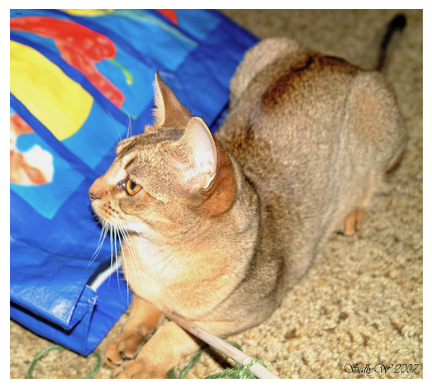

In [2]:
plt.axis("off")
input_img = Image.open(input_img_paths[9])
input_img = np.array(input_img)

plt.imshow(input_img)

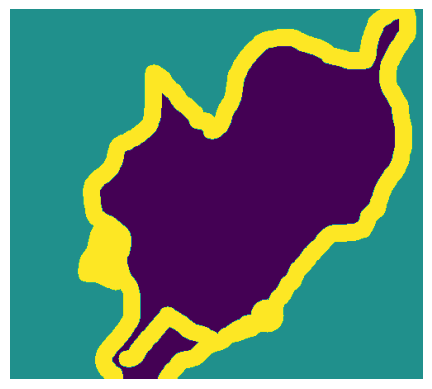

In [3]:
import torch
from torchvision import transforms

img = Image.open(target_paths[9]).convert("L")
img = np.array(img)        

def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127 
    plt.axis("off")
    plt.imshow(normalized_array)

display_target(img)

In [4]:
import numpy as np 
import random 
img_size = (200, 200)
num_imgs = len(input_img_paths)  
random.Random(1337).shuffle(input_img_paths) 
random.Random(1337).shuffle(target_paths) 

train_imgs = input_img_paths[1000:]
train_masks = target_paths[1000:]
test_imgs = input_img_paths[:1000]
test_masks = target_paths[:1000]

transform = transforms.Compose([
    transforms.Resize((200,200)),
    transforms.ToTensor()
])


In [5]:
from torch import Tensor
from torchvision.transforms import Compose

class SegmentationDataset(Dataset):
    """A custom dataset class"""

    def __init__(self, images: list, masks: list, transforms: Compose) -> None:
        # Get paths to images and masks
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self) -> int:
        # Return the number of images
        return len(self.images)

    def __getitem__(self, index: int) -> (Tensor, Tensor):
        # Get image and mask paths
        image_path = self.images[index]
        mask_path = self.masks[index]

        # Open image and convert to RGB
        image = Image.open(image_path).convert('RGB')
        # Open mask and convert to grayscale
        mask = Image.open(mask_path).convert('L')
        mask = np.array(mask)
        
        mask = mask.astype("uint8") - 1
        mask = Image.fromarray(mask)
        
        image = self.transforms(image)
        mask = self.transforms(mask)
        mask = mask*255
        mask = mask.squeeze().to(torch.int64)
        
        # Return the image and corresponding mask
        return image, mask

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.relu5 = nn.ReLU()
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu6 = nn.ReLU()
        self.convtrans1 = nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1)
        self.relu7 = nn.ReLU()
        self.convtrans2 = nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.relu8 = nn.ReLU()
        self.convtrans3 = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1)
        self.relu9 = nn.ReLU()
        self.convtrans4 = nn.ConvTranspose2d(128,128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.relu10 = nn.ReLU()
        self.convtrans5 = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.relu11 = nn.ReLU()
        self.convtrans6 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.relu12 = nn.ReLU()
        self.conv7 = nn.Conv2d(64, num_classes, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.conv6(x)
        x = self.relu6(x)
        x = self.convtrans1(x)
        x = self.relu7(x)
        x = self.convtrans2(x)
        x = self.relu8(x)
        x = self.convtrans3(x)
        x = self.relu9(x)
        x = self.convtrans4(x)
        x = self.relu10(x)
        x = self.convtrans5(x)
        x = self.relu11(x)
        x = self.convtrans6(x)
        x = self.relu12(x)
        x = self.conv7(x)
        return x

# Create an instance of the PyTorch model
num_classes = 3
model = CustomModel(num_classes)

import torchsummary
model.to('cuda')
torchsummary.summary(model, (3,200,200), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           1,792
              ReLU-2         [-1, 64, 100, 100]               0
            Conv2d-3         [-1, 64, 100, 100]          36,928
              ReLU-4         [-1, 64, 100, 100]               0
            Conv2d-5          [-1, 128, 50, 50]          73,856
              ReLU-6          [-1, 128, 50, 50]               0
            Conv2d-7          [-1, 128, 50, 50]         147,584
              ReLU-8          [-1, 128, 50, 50]               0
            Conv2d-9          [-1, 256, 25, 25]         295,168
             ReLU-10          [-1, 256, 25, 25]               0
           Conv2d-11          [-1, 256, 25, 25]         590,080
             ReLU-12          [-1, 256, 25, 25]               0
  ConvTranspose2d-13          [-1, 256, 25, 25]         590,080
             ReLU-14          [-1, 256,

In [7]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss

train_set = SegmentationDataset(train_imgs, train_masks, transform)
val_set = SegmentationDataset(test_imgs, test_masks, transform)

# Define batch size
batch_size = 32

# Create data loaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Calculate the number of train and test steps
train_steps = len(train_set) // batch_size
val_steps = len(val_set) // batch_size

# Initiate a train history
history = {'train_loss': [], 'val_loss': []}

best_val_loss = 9999
model = model.to('cuda')
epochs = 50
# Train the model
print("Start Training")
for epoch in range(epochs):
    print('EPOCH: {}'.format(epoch))
    # Set the model in learning mode
    model.train()
    # Initiate the train and test loss values
    train_loss = 0.
    val_loss = 0.

    # Loop through the training data
    for i, (images, targets) in enumerate(train_loader):
        # Move data to the device
        images, targets = images.to('cuda'), targets.to('cuda')
        # Forward pass
        pred = model(images)
        loss = criterion(pred, targets)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        # Update weights
        optimizer.step()
        # Update the train loss value
        train_loss += loss

    # Evaluate the model
    with torch.no_grad():
        # Set the model in evaluation mode
        model.eval()
        # Loop through the test data
        for (images, targets) in val_loader:
            # Move data to the device
            images, targets = images.to('cuda'), targets.to('cuda')
            # Predict values and calculate the loss
            pred = model(images)
            loss = criterion(pred, targets)
            # Update the test loss value
            val_loss += loss

    # Calculate the average train and loss values
    avg_train_loss = train_loss / train_steps
    avg_val_loss = val_loss / val_steps
    # Update the training history
    history['train_loss'].append(avg_train_loss.cpu().detach().numpy())
    history['val_loss'].append(avg_val_loss.cpu().detach().numpy())

    if avg_val_loss < best_val_loss:
        torch.save(model.state_dict(), "oxford_segmentation.pt")
        best_val_loss = avg_val_loss

    print('Train loss: {} Val loss: {}'.format(avg_train_loss, avg_val_loss))


Start Training
EPOCH: 0
Train loss: 0.8613548874855042 Val loss: 0.7755253911018372
EPOCH: 1
Train loss: 0.7340902090072632 Val loss: 0.701288104057312
EPOCH: 2
Train loss: 0.6503803730010986 Val loss: 0.6141387820243835
EPOCH: 3
Train loss: 0.5771397948265076 Val loss: 0.5392100214958191
EPOCH: 4
Train loss: 0.5201314091682434 Val loss: 0.5113673210144043
EPOCH: 5
Train loss: 0.48391762375831604 Val loss: 0.4815357029438019
EPOCH: 6
Train loss: 0.45340514183044434 Val loss: 0.44122615456581116
EPOCH: 7
Train loss: 0.4316805601119995 Val loss: 0.40829262137413025
EPOCH: 8
Train loss: 0.413453072309494 Val loss: 0.4082506000995636
EPOCH: 9
Train loss: 0.39861562848091125 Val loss: 0.5167972445487976
EPOCH: 10
Train loss: 0.39031893014907837 Val loss: 0.43039917945861816
EPOCH: 11
Train loss: 0.38319557905197144 Val loss: 0.4097934663295746
EPOCH: 12
Train loss: 0.37205609679222107 Val loss: 0.38115569949150085
EPOCH: 13
Train loss: 0.35916420817375183 Val loss: 0.4054938554763794
EPOCH:

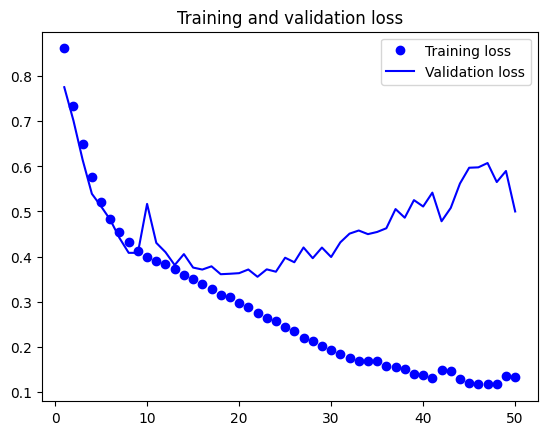

In [8]:
epochs = range(1, len(history["train_loss"]) + 1)
loss = history['train_loss']
val_loss = history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

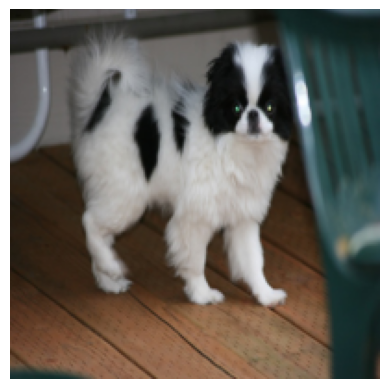

In [9]:
model.load_state_dict(torch.load('oxford_segmentation.pt'))
model.to('cpu')
model.eval()

i = 4
test_image = val_set[4][0].permute(1,2,0)
plt.axis("off")
plt.imshow(test_image)

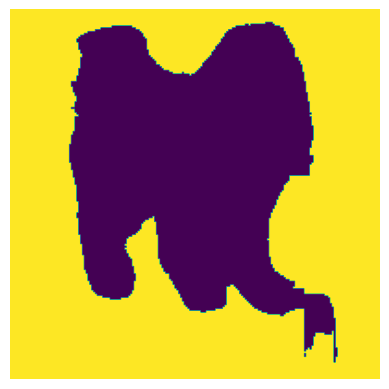

In [17]:
mask = model(torch.unsqueeze(val_set[4][0],0))[0]
mask = mask.detach().numpy()

def display_predicted_mask(pred):
    pred = np.argmax(pred, axis=0)
    pred = pred*127
    plt.axis("off")
    plt.imshow(pred)

display_predicted_mask(mask)